# Tâche #2 : Classification d'incidents avec un réseau  récurrent et des *embeddings* Spacy

Cette tâche est similaire à la précédente et vous réutilisez les mêmes fichiers d’entraînement, de validation et de test. Cependant, vous devez utiliser des réseaux récurrents pour classifier les textes. Plus particulièrement, vous devez entraîner un réseau de neurones LSTM pour encoder les textes et une couche linéaire pour faire la classification des textes. 

Les consignes pour cette tâche sont: 
- 	Nom du notebook : rnn.ipynb
- 	Tokenisation : Utilisation de Spacy. 
- 	Plongements de mots : Ceux de Spacy. 
- 	Normalisation : Aucune normalisation. 
- 	Structure du réseau : Un réseau LSTM avec 1 seule couche pour l’encodage de textes. Je vous laisse déterminer la taille de cette couche (à expliquer). 
- 	Analyse : Comparer les résultats obtenus avec un réseau unidirectionnel et un réseau bidirectionnel. Si vous éprouvez des difficultés à entraîner les 2 réseaux dans un même notebook, faites une copie et nommez le 2e fichier rnn-bidirectionnel.ipynb.
- 	Expliquez comment les modèles sont utilisés pour faire la classification d’un texte. 
- 	Présentez clairement vos résultats et faites-en l’analyse. 


Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle. 

## 1. Création du jeu de données (*dataset*)

In [ ]:
import spacy
import json
import numpy as np

spacy_model = spacy.load("en_core_web_md")
embedding_size = spacy_model.meta['vectors']['width']

In [35]:
# Définition des chemins vers les fichiers de données
train_data_path = './data/incidents_train.json'
dev_data_path = './data/incidents_dev.json'
test_data_path = './data/incidents_test.json'

def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
        
        text = [item["text"] for item in incident_list]
        target = np.array([int(item["label"]) for item in incident_list])
         
    return text, target


# Créer les DataFrames pour chaque partition de données
train_list, train_target = load_incident_dataset(train_data_path)
dev_list, dev_target = load_incident_dataset(dev_data_path)
test_list, test_target = load_incident_dataset(test_data_path)

# Affichage de l'information de base sur les DataFrames
display(f"Train data: text_size {len(train_list)}, target_size {len(train_target)}")
display(f"Dev data: text_size {len(dev_list)}, target_size {len(dev_target)}")
display(f"Test data: text_size {len(test_list)}, target_size {len(test_target)}")


# Vérification des premiers enregistrements dans l'ensemble d'entraînement
train_list[0]


'Train data: text_size 2475, target_size 2475'

'Dev data: text_size 531, target_size 531'

'Test data: text_size 531, target_size 531'

' At approximately 8:50 a.m. on October 29  1997  Employee #1 was painting a  single story house at 2657 7th Ave  Sacramento  CA. He was caulking around the  peak of the roof line on the west side of the house  20 ft above the ground.  He was working off of a 24 ft aluminum extension ladder so that his feet were  approximately 12 to 13 feet above the ground. Employee #1 fell and suffered a  concussion and two dislocated discs in his lower back and was hospitalized.  The ladder was not secured to prevent movement.                                 '

In [36]:
import numpy as np

# Cette section sert à ajouter les tokens de paddings et ceux de mots inconnus dans le vocabulaire
# On crée également le dictionnaire qui lie les id vers les mots du vocabulaire
# Et enfin on crée le dictionnaire qui lie les id vers leurs embeddings (ou vecteur de plongement)

padding_token = "<PAD>" 
unk_token = "<UNK>"    
zero_vec_embedding = np.zeros(embedding_size, dtype=np.float64)

id2word = {}
id2word[0] = padding_token 
id2word[1] = unk_token 

word2id = {}
word2id[padding_token] = 0
word2id[unk_token] = 1

id2embedding = {}
id2embedding[0] = zero_vec_embedding
id2embedding[1] = zero_vec_embedding

## 2. Gestion de plongements de mots (*embeddings*)

In [37]:
from torch import FloatTensor

# Génèrer la matrice des plongements de chaque mot d'une séquence donnée
def get_spacy_embeddings(text, spacy_analyzer=spacy_model):
    doc = spacy_analyzer(text)
    embeddings = [token.vector for token in doc]
    return FloatTensor(embeddings)

In [38]:
# Remplissage des dictionnaires id vers mot et id vers embedding

word_index = 2
vocab = word2id.keys()
for question in train_list:
    for word in spacy_model(question):
        if word.text not in vocab:
            word2id[word.text] = word_index
            id2word[word_index] = word.text
            id2embedding[word_index] = word.vector
            word_index += 1

La classe SpacyDataset est conçue pour faciliter la préparation des données textuelles pour l'entraînement du modèle. Elle permet de tokenizer les textes, de les représenter sous forme de tensors compatibles avec PyTorch, et de fournir les cibles associées pour chaque exemple.

In [39]:
from torch.utils.data import Dataset, DataLoader
from torch import LongTensor
from typing import List
import numpy as np

class SpacyDataset(Dataset):
    def __init__(self, dataset: List[str] , target: np.array, wordId: dict, model=spacy_model):
        self.dataset = dataset
        self.doc_embeddings = [None for _ in range(len(dataset))]
        self.targets = target
        self.tokenizer = model
        self.word2id = wordId

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.doc_embeddings[index] is None:
            self.doc_embeddings[index] = self.tokenize(self.dataset[index])
        return LongTensor(self.doc_embeddings[index]), LongTensor([self.targets[index]]).squeeze(0)

    def tokenize(self, sentence):
        tokens = [word.text for word in self.tokenizer(sentence)]
        return [self.word2id.get(token, 1) for token in tokens]  # get(token, 1) retourne 1 par défaut si mot inconnu

In [40]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

# Ajoute le padding dans toutes les séquences d'une batch
# On prend la phrase la plus longue du lot et on ajoute du padding à toutes les autres pour avoir des tailles similaires

def pad_batch(batch):
    x = [x for x,y in batch]
    x_true_length = [len(x) for x,y in batch]
    y = torch.stack([y for x,y in batch], dim=0)
    return ((pad_sequence(x, batch_first=True), x_true_length), y)

In [41]:
# On finalise la construction des 3 jeux de données et leurs dataloaders
train_dataset = SpacyDataset(train_list, train_target, word2id)
valid_dataset = SpacyDataset(dev_list, dev_target, word2id)
test_dataset = SpacyDataset(test_list, test_target, word2id)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True, collate_fn=pad_batch)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=pad_batch)

In [42]:
data = next(iter(train_dataloader))
print(data)


((tensor([[   2,    3,    4,  ...,    0,    0,    0],
        [   2,    3,    4,  ...,    0,    0,    0],
        [   2,  107,  906,  ...,    0,    0,    0],
        ...,
        [   2,  107,    8,  ...,    0,    0,    0],
        [   2,  107,  202,  ...,    0,    0,    0],
        [   2,  107, 1020,  ...,    0,    0,    0]]), [179, 75, 63, 204, 42, 162, 159, 182, 117, 228, 252, 107, 87, 173, 141, 66]), tensor([0, 5, 5, 5, 5, 5, 5, 8, 0, 7, 5, 0, 5, 2, 0, 7]))


## 3. Création de modèle(s)

In [43]:
# Creation d'un embedding layer qui sera utilisé dans le modele principal

vocab_size = len(id2embedding)
embedding_layer = np.zeros((vocab_size, embedding_size), dtype=np.float32)

for token_id, embedding in id2embedding.items():
    embedding_layer[token_id,:] = embedding

embedding_layer = torch.from_numpy(embedding_layer)

print("Taille de la couche d'embeddings:", embedding_layer.shape)

Taille de la couche d'embeddings: torch.Size([11642, 300])


### Explication des modèles utilisés pour faire la classification d’un texte

Ce code représente la méthode forward d'un modèle PyTorch destiné à traiter des séquences de texte pour la classification. Il commence par encoder les mots en vecteurs d'embedding, puis utilise une couche récurrente pour traiter les séquences de manière séquentielle, capturant ainsi les dépendances entre les mots. Si le modèle est bidirectionnel, il fusionne les états cachés des deux directions, sinon il utilise simplement l'état caché de la dernière étape. Enfin, la sortie est transformée par une couche de classification pour produire les prédictions finales.Il est conçu pour gérer efficacement des séquences de longueurs variables grâce à l'utilisation de pack_padded_sequence, ce qui le rend adapté à la classification de texte.

In [44]:
vocab_size = len(id2embedding)
embedding_layer = np.zeros((vocab_size, embedding_size), dtype=np.float32)
for token_id, embedding in id2embedding.items():
    embedding_layer[token_id,:] = embedding
embedding_layer = torch.from_numpy(embedding_layer)

print("Taille de la couche d'embeddings:", embedding_layer.shape)



Taille de la couche d'embeddings: torch.Size([11642, 300])


In [14]:
# import torch.nn as nn
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# class LSTMClassifier(nn.Module):
#     def __init__(self, embeddings, hidden_state_size, nb_classes) :
#         super(LSTMClassifier, self).__init__()
#         self.embedding_layer = nn.Embedding.from_pretrained(embeddings)
#         self.embedding_size = embeddings.size()[1]
#         self.rnn = nn.LSTM(self.embedding_size, hidden_state_size, 1, batch_first=True)
#         self.classification_layer = nn.Linear(hidden_state_size, nb_classes)

#     def forward(self, x, x_lengths):
#         x = self.embedding_layer(x)
#         packed_batch = pack_padded_sequence(x, x_lengths, batch_first=True, enforce_sorted=False)
#         x, last_hidden_state = self.rnn(packed_batch)  # On utilise le hidden state de la dernière cellule
#         # x = last_hidden_state.squeeze()  # Le LSTM a une seule couche, on retire cette dimension
#         x = self.classification_layer(x)
#         x = nn.functional.softmax(x)
#         return x

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# Modèle rnn avec une couche de plongements, une couche de LSTM et une tête de prédiction en sortie

class LSTMClassifier(nn.Module):
    def __init__(self, embeddings, hidden_state_size, nb_classes, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings)
        self.rnn = nn.LSTM(input_size=embeddings.size()[1], hidden_size=hidden_state_size, batch_first=True, bidirectional=bidirectional)
        multiplier = 2 if bidirectional else 1
        self.classification_layer = nn.Linear(hidden_state_size * multiplier, nb_classes)

    def forward(self, x, x_lenght):
        x = self.embedding_layer(x)
        packed_batch = pack_padded_sequence(x, x_lenght, batch_first=True, enforce_sorted=False)
        packed_output, (hidden_state, cell_state) = self.rnn(packed_batch)

        if self.rnn.bidirectional:
            # Concatenating the hidden states of the last time step from both directions
            x = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        else:
            x = hidden_state[-1,:,:]  # Taking the last time step of the hidden state

        x = self.classification_layer(x)
        return x


Après de nombreux essais et pour des raisons de faisabilité en termes de temps et de ressources disponibles, il a été concclu que la taille de la couche cachée de 100 est la meilleure option pour cette tâche de classification en raison de son équilibre entre la capacité du modèle à apprendre des motifs complexes et sa capacité à généraliser à partir des données 

In [16]:
from poutyne import set_seeds

set_seeds(42)
hidden_size = 100
nb_classes = 9

### Modele unidirectionnel

In [45]:
# Modele unidirectionnel
model = LSTMClassifier(embedding_layer, hidden_size, nb_classes)

### Modele bidirectionnel

In [46]:

bidirectional_model = LSTMClassifier(embedding_layer, hidden_size, nb_classes, bidirectional=True)

## 4. Fonctions utilitaires

La fonction "display_plots" est conçue pour visualiser les résultats d'entraînement d'un modèle en affichant des graphiques d'évaluation tels que la précision, le score F1 et la perte

In [47]:
from IPython.display import Image

def display_plots(experiment):
# Specify the path to your PNG image file
    directory = f"{experiment.directory}/plots"

    acc = f"{directory}/acc.png"
    f1 = f"{directory}/fscore_macro.png"
    loss = f"{directory}/loss.png"

    # Display the PNG image
    display(Image(filename=acc), Image(filename=f1), Image(filename=loss))

## 5. Entraînement de modèle(s)

### Entrainement unidirectionel

In [48]:
from poutyne.framework import Experiment
from poutyne import set_seeds

set_seeds(42)
hidden_size = 100
optimizer = "ADAM"

directory_name = 'model_task2/unidirectional'

experiment = Experiment(directory_name,
                        model,
                        optimizer = optimizer,
                        task="classification",
                        loss_function="cross_entropy",
                        )

In [49]:
logging = experiment.train(train_dataloader, valid_dataloader, epochs=30, disable_tensorboard=True)

Loading weights from model_task2/unidirectional/checkpoint.ckpt and starting at epoch 7.
Loading optimizer state from model_task2/unidirectional/checkpoint.optim and starting at epoch 7.
Loading random states from model_task2/unidirectional/checkpoint.randomstate and starting at epoch 7.
Epoch:  7/30 Train steps: 155 Val steps: 34 1m39.56s loss: 0.561206 acc: 80.686869 fscore_macro: 0.678447 val_loss: 1.077642 val_acc: 63.841808 val_fscore_macro: 0.408249
Epoch:  8/30 Train steps: 155 Val steps: 34 42.73s loss: 0.460975 acc: 84.646465 fscore_macro: 0.728836 val_loss: 1.116948 val_acc: 64.595104 val_fscore_macro: 0.399340
Epoch:  9/30 Train steps: 155 Val steps: 34 42.76s loss: 0.387176 acc: 87.272727 fscore_macro: 0.785075 val_loss: 1.159341 val_acc: 64.783428 val_fscore_macro: 0.402746
Epoch: 10/30 Train steps: 155 Val steps: 34 43.08s loss: 0.308007 acc: 90.020202 fscore_macro: 0.833317 val_loss: 1.225417 val_acc: 65.348399 val_fscore_macro: 0.424854
Epoch: 11/30 Train steps: 155 Val

### Entrainement bidirectionel

In [50]:
directory_name = "model_task2/bidirectional"

bidirectional_experiment = Experiment(directory_name,
                        bidirectional_model,
                        optimizer = optimizer,
                        task="classification",
                        loss_function="cross_entropy",
                        )

In [51]:
logging = bidirectional_experiment.train(train_dataloader, valid_dataloader, epochs=30, disable_tensorboard=True)

Loading weights from model_task2/bidirectional/checkpoint.ckpt and starting at epoch 3.
Loading optimizer state from model_task2/bidirectional/checkpoint.optim and starting at epoch 3.
Loading random states from model_task2/bidirectional/checkpoint.randomstate and starting at epoch 3.
Epoch:  3/30 Train steps: 155 Val steps: 34 1m23.29s loss: 1.028541 acc: 64.525253 fscore_macro: 0.368225 val_loss: 1.162230 val_acc: 58.757062 val_fscore_macro: 0.321228
Epoch 3: val_acc improved from 58.56874 to 58.75706, saving file to model_task2/bidirectional/checkpoint_epoch_3.ckpt
Epoch:  4/30 Train steps: 155 Val steps: 34 1m21.57s loss: 0.898583 acc: 69.212121 fscore_macro: 0.452115 val_loss: 1.122566 val_acc: 60.263654 val_fscore_macro: 0.353379
Epoch 4: val_acc improved from 58.75706 to 60.26365, saving file to model_task2/bidirectional/checkpoint_epoch_4.ckpt
Epoch:  5/30 Train steps: 155 Val steps: 34 1m20.73s loss: 0.752363 acc: 74.787879 fscore_macro: 0.569151 val_loss: 1.166039 val_acc: 59

## 6. Évaluation et analyse de résultats

In [22]:
logging = bidirectional_experiment.train(train_dataloader, valid_dataloader, epochs=50, disable_tensorboard=True)

Epoch:  1/50 Step:  34/155  21.94% |████▍               |ETA: 5m11.12s loss: 1.815479 acc: 37.500000

### Evaluation unidirectionnelle

Found best checkpoint at epoch: 16
lr: 0.001, loss: 0.0794202, acc: 98.303, fscore_macro: 0.97638, val_loss: 1.56389, val_acc: 67.6083, val_fscore_macro: 0.442788
Loading checkpoint model_task2/unidirectional/checkpoint_epoch_16.ckpt
Running test
Test steps: 531 13.28s test_loss: 1.658509 test_acc: 62.335217 test_fscore_macro: 0.506880      


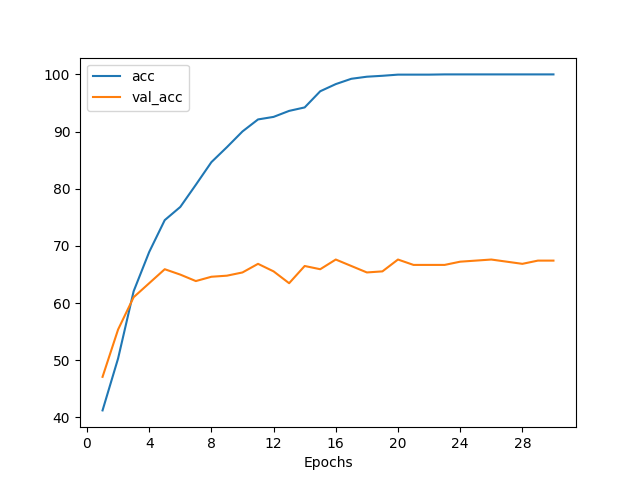

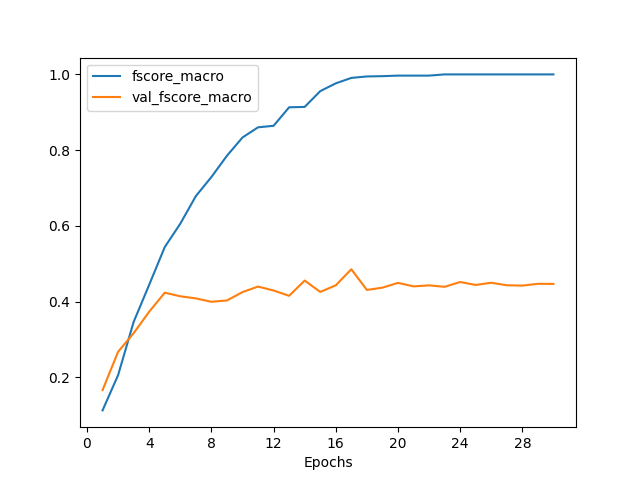

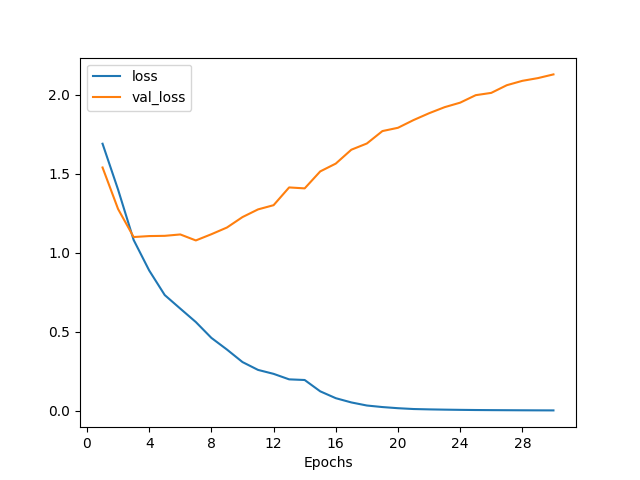

In [52]:
experiment.test(test_dataloader)
display_plots(experiment)

### Réseau LSTM Unidirectionnel :

Précision (Accuracy) : 62.34%;
Score F1 Macro : 50.69%;
Perte (Loss) : 1.6585.

Le modèle unidirectionnel obtient une précision de 62.34% sur les données de test alors que durant l'entrainement il a atteint 98.30%, ce qui signifie qu'il n'apprend pas très bien des données fournies mais fait du surentrainement. Le score F1 Macro est de 50.69%, ce qui indique une bonne capacité du modèle à maintenir un équilibre entre la précision et le rappel pour différentes classes. Cependant, la perte est de 1.6585, ce qui représente une grande quantité d'erreur du modèle.


### Evaluation bidirectionnelle

Found best checkpoint at epoch: 11
lr: 0.001, loss: 0.158424, acc: 96.2424, fscore_macro: 0.942598, val_loss: 1.45412, val_acc: 64.7834, val_fscore_macro: 0.439066
Loading checkpoint model_task2/bidirectional/checkpoint_epoch_11.ckpt
Running test
Step:   1/531   0.19% |                    |ETA: 2.47s test_loss: 0.019364 test_acc: 100.000000

Test steps: 531 4.39s test_loss: 1.486060 test_acc: 62.335217 test_fscore_macro: 0.468304      


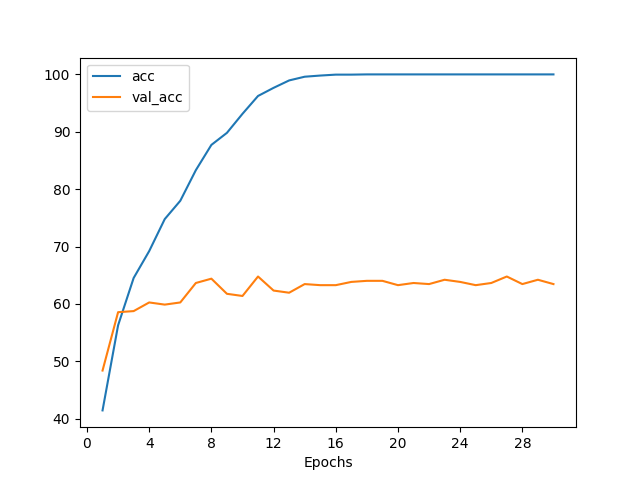

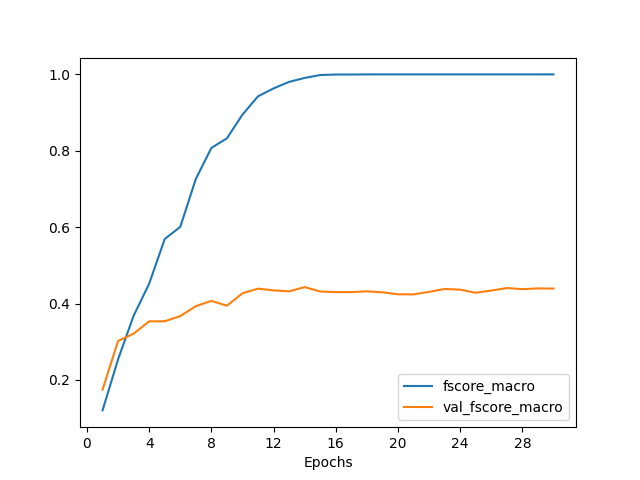

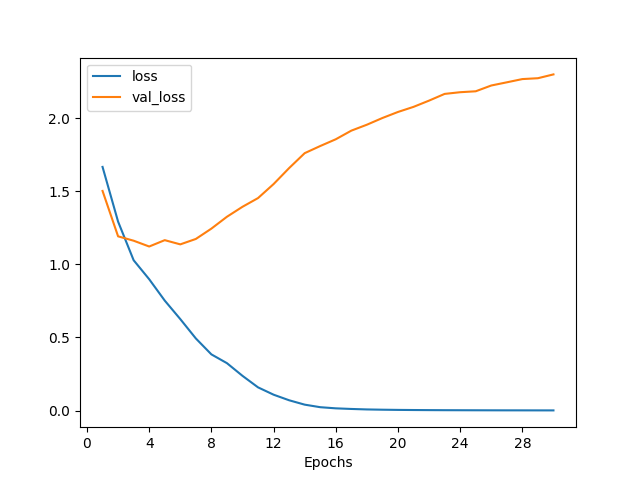

In [53]:
bidirectional_experiment.test(test_dataloader)
display_plots(bidirectional_experiment)


### Réseau LSTM Bidirectionnel :

Le modèle bidirectionnel obtient également une précision de 62.34% alors que durant l'entrainement il a atteint 96.24%, ce qui signifie que de façon similaire au modèle unidirectionnel, il n'apprend pas très bien des données fournies mais fait du surentrainement.
Cependant, le score F1 Macro est légèrement inférieur à 46.83%, ce qui indique que le modèle bidirectionnel a plus de difficulté à gérer les classes de manière équilibrée par rapport au modèle unidirectionnel.
La perte est plus faible, à 1.4861, ce qui peut indiquer que le modèle bidirectionnel a convergé un peu plus rapidement pendant l'entraînement.

### Comparaison entre les résultats obtenus avec un réseau unidirectionnel et un réseau bidirectionnel

Bien que les deux modèles présentent des précisions similaires, il semble que le modèle unidirectionnel soit plus efficace pour équilibrer les performances entre les classes en termes de score F1 Macro. Cette similarité dans les résultats peut être attribuée à la quantité de données : le problème de classification de texte etant relativement simple, et étant donné que la quantité de données d'entraînement n'est pas très élevée, les modèles plus complexes tels que les LSTM bidirectionnels pourraient ne pas montrer d'amélioration significative par rapport aux modèles unidirectionnels.